<a href="https://colab.research.google.com/github/DylanGraves/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random

random.seed(42)
# dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head(10)

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True
5,False,20.484877,True
6,False,167.354007,True
7,False,447.750546,False
8,True,57.935255,True
9,True,292.649431,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [36]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DylanGraves/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

df.head(25)

# Got the data into a dataframe by linking to the raw data.

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182
5,5,58,103,165
6,6,55,161,107
7,7,21,188,37
8,8,55,216,79
9,9,50,127,267


In [2]:
df.shape

# Making sure that I got all the data that was suppose to be in there.

(1200, 4)

In [0]:
import matplotlib.pyplot as plt
import numpy as np

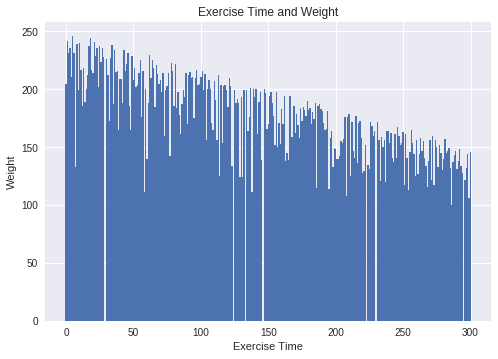

In [31]:
plt.bar(df['exercise_time'], df['weight'], width = 1)
plt.xlabel('Exercise Time')
plt.ylabel('Weight')
plt.title('Exercise Time and Weight')
plt.show()

# With this very rough graph, it looks like there is a strong correlation between exercise and weight. As exercise goes up then weight goes down.
# However, we need to make sure that this is actually what the data is telling us, so let us examine the other variables in the dataset.

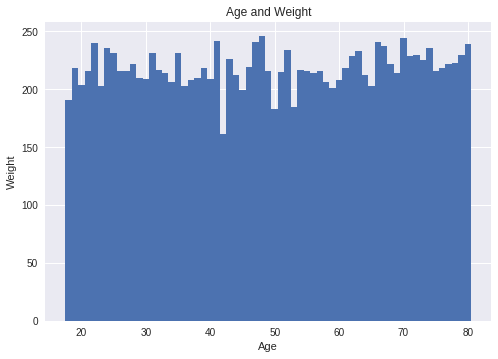

In [21]:
plt.bar(df['age'], df['weight'], width = 1)
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age and Weight')
plt.show()

# There doesn't seem to be much correlation between age and weight.
# Let's check out age and exercise time next.

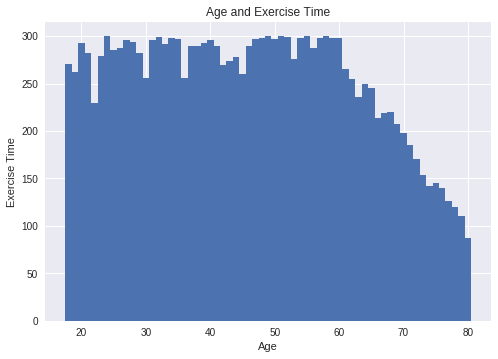

In [25]:
plt.bar(df['age'], df['exercise_time'], width = 1)
plt.xlabel('Age')
plt.ylabel('Exercise Time')
plt.title('Age and Exercise Time')
plt.show()

# There doesn't seem to be a huge correlation between age and exercise until people hit around 60 years old, when the amount of exercise time they do
# steadily decreases, presumably because as they get older it becomes more difficult to do physical activites.
# Interestingly, in the graph charting age and weight there does not seem to be a correlation between the two, but there is a correlation between
# exercise and weight. Yet, old people are not getting much exercise but their weight doesn't seem to reflect this.
# This might be all of those "valleys" we see in the exercise time and weight graph. Those are older people who, while exercising less, have
# retained their lower weight.

# But I think there is only so much these crude bar graphs can tell us. I would like to see this same data but with perhaps some better tools.

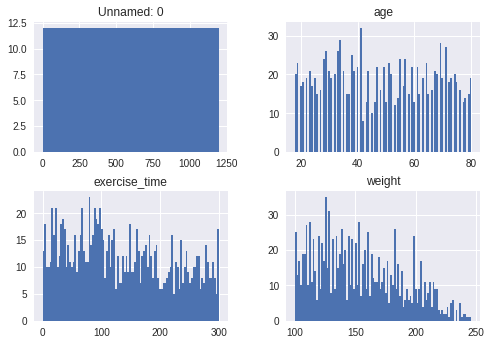

In [35]:
df.hist(bins=100);

# Quick graph to take a look at the data. I probably should have done this first. lol

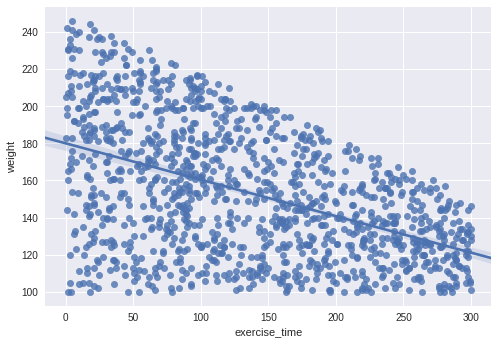

In [39]:
import seaborn as sns

sns.regplot(x="exercise_time", y="weight", data=df);

# Using seaborn and scatterplots for a different view of the data.

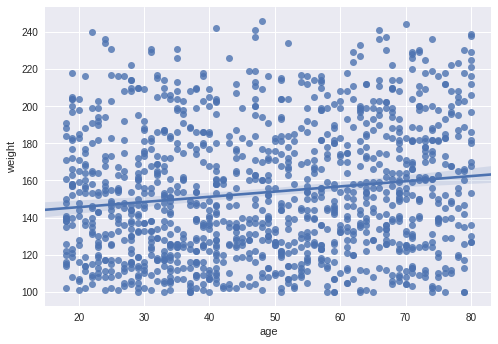

In [40]:
sns.regplot(x="age", y="weight", data=df);

In [46]:
age_bins = pd.cut(df['age'], 4)  # 4 bins
weight_bins = pd.cut(df['weight'], 4) # 4 bins
pd.crosstab(weight_bins, age_bins, normalize='columns')

# pd.crosstab(df['weight'], df['age'], normalize='columns')

age,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
weight,,,,
"(99.854, 136.5]",0.389408,0.442623,0.391304,0.288591
"(136.5, 173.0]",0.383178,0.304918,0.307971,0.322148
"(173.0, 209.5]",0.161994,0.196721,0.228261,0.261745
"(209.5, 246.0]",0.065421,0.055738,0.072464,0.127517


In [47]:
exercise_bins = pd.cut(df['exercise_time'], 4)
pd.crosstab(weight_bins, exercise_bins, normalize='columns')

# Most of my comments on this stuff will be in the questions section below.

exercise_time,"(-0.3, 75.0]","(75.0, 150.0]","(150.0, 225.0]","(225.0, 300.0]"
weight,,,,
"(99.854, 136.5]",0.230986,0.290698,0.459770,0.633333
"(136.5, 173.0]",0.250704,0.337209,0.398467,0.366667
"(173.0, 209.5]",0.301408,0.316860,0.141762,0.000000
"(209.5, 246.0]",0.216901,0.055233,0.000000,0.000000


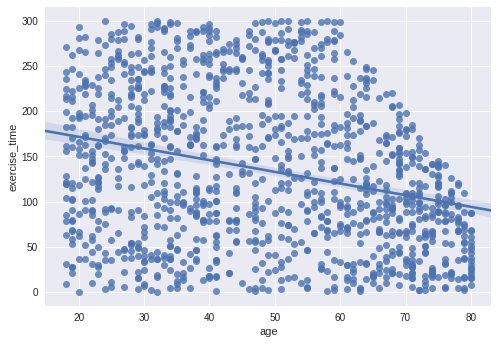

In [41]:
sns.regplot(x="age", y="exercise_time", data=df);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

All of the variables are continuous in theory, although you might want to group age into discrete buckets like years.

2.  What are the relationships between the variables?

It seems that there is a negative correlation between exercise and weight. I.e. the more you exercise the less you will weigh, on average. Weight only increases slightly as age increases. And age doesn't seem to correlate with exercise time that much until one reaches the age of sixty in which exercise time drops relatively steeply.

3.  Which relationships are "real", and which spurious?

Short answer: Exercise is correlated with weight loss, which seems to be correct. And age correlates with weight gain, but this is most likely due to the decrease in exercise as one ages.

Unfortunately we cannot determine the actual causal relationships from this data. One of the relationships seem to be that once one reaches sixty they decrease the amount they exercise. One possible interpreation of this is that as you age you are less able to exercise, but another interpretation is that exercise actually either kills you or causes you to be unhealthy enough that you are not able to exercise much. If that interpretation was true, you would likely see a similar pattern. To put it another way, you could imagine the scatterplot above as not actually a graph of age and exercise time, but of age and lead consumption. Someone who consumes large amounts of lead is probably unlikely to live past 60 and thus there will be no data point of someone with high lead consumption that is also 70 years old. The point that I'm trying to make is that it seems that exercise makes you weigh less, but you can't be 100% sure.
The correlation between age and weight is most likely spurious. Age does not make you weigh more, old people just exercise less.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)